<a href="https://colab.research.google.com/github/Gabriel-Aspen/NFL-sentiment-analysis/blob/updated/eagles_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/My Drive/Colab Notebooks')
current_dir = os.getcwd()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Download these two libraries we will be using

In [0]:
pip install SpeechRecognition

In [0]:
pip install vaderSentiment

##Sentiment Analysis from Transcibed Audio
1. Speech is transcribed in 10 second intervals using Google Web Speech API
2. The transcript is passed through vaderSentiment's SentimentIntensityAnalyzer. The metric I've chosen is compound because it's aggregation of positive, negative and neutral sentiment
3. The data is smoothed using a rolling mean

Import libraries

In [0]:
import speech_recognition as spr
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

Transcribe the audio with Google's web speech API using speech_recognition
- We set window_size = 10 for 10 second intervals, however you can go longer or shorter
- Depending on the size of the .wav file you may need to adjust the number of steps. This file is about 2.5 hours long (9000 seconds, or 900 10-second intervals)
- Overlapping the windows might allow us to better capture the context of what the announcer is saying. This code let's you specify what percent (as a decimal) you want window i to overlap with window i+1. For now I set it as 0

In [0]:
infile = 'nfl_SA/eagles.wav' #path to the .wav file

def makeTranscript(audio_file = False, steps=900, window_size=10, overlap= 0):
  if audio_file == False:
    return 'no input'
  else:
    transcript = []
    for step in range(steps):
      r = spr.Recognizer()
      with spr.AudioFile(audio_file) as source:
          offset_multi = window_size * (1-overlap) # overlap- how much to overlap with the next window
          audio = r.record(source, duration=window_size , offset=step * offset_multi)
      try:
          text = r.recognize_google(audio) #google web API recognizer- however there are many other options
          transcript.append([text])
      except spr.UnknownValueError:
          text = 'error'
      except spr.RequestError as e:
          False
    return np.array(transcript)

transcript = makeTranscript(infile)

Generate VADER sentiment scores from the transcript

In [0]:
def vaderAnalyzer(transcript, element= 'compound'):
  analyzer_obj = SentimentIntensityAnalyzer()
  sent_dict = []
  for i in range(int(transcript.size)):
    score_set = analyzer_obj.polarity_scores(str(transcript[i])) #returns a dictionary of different types of sentiment scores
    sent_dict.append(score_set)
  chosen_element = [] # can be positive, negative, neutral or compound
  for i in range(len(sent_dict)):
    chosen_element.append(sent_dict[i][element])
  return chosen_element

scores = vaderAnalyzer(transcript, element= 'compound')

Plot the scores

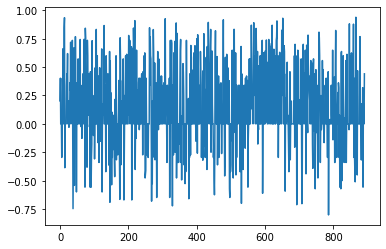

In [9]:
plt.plot(scores) # 10 second intervals = 9000 total seconds

The data is very noisy, try smoothing it out using a rolling mean (average within a window of points)

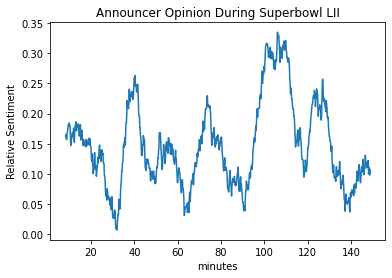

In [65]:
df = pd.DataFrame(scores, columns=['scores'])
df['rolling_mean'] = df.rolling(window=50).mean() # window size of 50 points
df['minutes'] = ((df.index +1) *10)/60 # put X in terms of minutes
plt.plot(df.minutes, df.rolling_mean)

plt.title('Announcer Opinion During Superbowl LII')
plt.xlabel('minutes')
plt.ylabel('Relative Sentiment');

Notice how the sentiment scores are now all above 0. Since the data is being averaged across neighbors it no longer reflects the exact sentiment at a given timepoint. However this still allows us to visualize the general trend

Save the scores and transcript as pickle files

In [0]:
#sentiment scores
outfile_name = 'nfl_SA/eagles_900-10-0_vader-comp.pickle' #900 steps, 10 second windows, 0 overlap, VADER compound score
outpath = os.path.join(current_dir, outfile_name)
with open(outpath, 'wb') as pickle_out:
    pickle.dump(scores, pickle_out)
    pickle_out.close()

#transcript
outfile_name = 'nfl_SA/eagles_900-10-0_vader-comp_transcript.pickle'
outpath = os.path.join(current_dir, outfile_name)
with open(outpath, 'wb') as pickle_out:
    pickle.dump(transcript, pickle_out)
    pickle_out.close()

----

Loading the data back in

In [0]:
import pickle

#load the scores variable
infile_name = 'nfl_SA/pickle_files/eagles_900-10-0_vader-comp.pickle'
inpath = os.path.join(current_dir, infile_name)
with open(inpath, 'rb') as pickle_in:
    scores = pickle.load(pickle_in)
  
#load the transcript variable
infile_name = 'nfl_SA/pickle_files/eagles_900-10-0_vader-comp_transcript.pickle'
inpath = os.path.join(current_dir, infile_name)
with open(inpath, 'rb') as pickle_in:
    transcript = pickle.load(pickle_in)